<a href="https://colab.research.google.com/github/MahlaMirali/MachineLearning_Lentil_Seed_Coat_Colour_and_Phenolics/blob/master/Seed_color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries/ file

In [0]:
pip install shap

In [0]:
from google.colab import files
import io
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import numpy as np
from scipy import sparse
from collections import Counter
import itertools
from random import sample
import scipy
from scipy import stats
from scipy.stats import chi2_contingency
from pprint import pprint
import warnings
import shap

#ML from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# ANN
import tensorflow
import keras
from keras.models import Sequential 
from keras.layers import Dense,Activation,Dropout 
from keras.utils import np_utils
from keras.optimizers import Adam

# Upload/import the file

In [3]:
# upload the file into google colab
uploaded = files.upload()

Saving ML_4colour.csv to ML_4colour.csv


In [4]:
# import the file into a dataframe
df = pd.read_csv(io.BytesIO(uploaded['ML_4colour.csv']))
# drop the rows with missing data
df = df.drop(df[(df.cat == 0)| (df['1748.2'] == 0)].index)
print(len(df))
# omitting some of the columns
df = df.drop(['Folder','genotypes','location','cotyledon','rep',
                         '4_sal','4_coum','3_cinn','cat_13C'], axis = 1)
df.head(5)

190


,hull,vanil_4gluc,querc_glucI,cat,epi_cat,cat_gluc,gallo,epi_gallo,epi_cat_gall,epi_gallo_gall,A2,B1,CC_I,CC_II,B2,CCC_I,CCC_II,C1,CCC_III,kaempf_rhamn,querc_di_glucI,kaemp_di_rut,malv_3galact,querc_3_4di_gluc,kaemp_3robin_7rhamn,lut_3_7di_gluc,lut_di_gluc,kaemp_rhamn_gluc_I,kaemp_rhamn_gluc_II,resv_3gluc,querc_3galact,querc_3rutin,querc_3gluc,myr_3rhamn,kaemp_3rutin,lut_7gluc,kaemp_7neohesp,kaem_3gluc,querc_3rhamn,apig_7gluc,...,kaemp,querc_glucIII,731.7,1155.9I,1155.9II,1444.1I,1444.1II,595.6I,595.6II,595.6IV,609.6,883.7I,883.7II,883.7IV,899.7I,899.7II,899.7III,915.6II,915.6III,915.6IV,1171.8I,1171.8II,1171.8III,1187.8I,1187.8II,1187.8III,1460.1I,1460.1II,1475.8I,1475.8II,1492.2I,1492.2II,1748.2,1764.4,1204.8I,1204.8II,1204.8III,1509.2I,1509.2II,1525.1
0,brown,0.246700,0.100459,0.616302,0.019288,7.913565,0.252229,0.004858,0.002159,0.000437,0.004524,0.229530,0.938848,0.121226,0.016215,1.839570,0.261486,0.001049,0.328785,56.274995,0.327864,546.792155,0.000000,0.001176,19.574256,0.001615,1.433044,0.349899,0.110363,0.331385,0.004651,0.093082,0.017217,0.186530,0.036433,0.050826,0.004043,0.078000,0.249120,0.022992,...,0.000515,0.018667,0.632827,3.911181,3.791208,0.976440,1.047954,2.824455,1.565748,12.060314,0.891967,25.610989,6.543969,1.032335,5.019163,2.874199,20.554053,0.927460,1.477010,1.487925,8.197364,4.288911,3.212514,13.444427,3.935404,1.641315,1.701887,1.452669,3.827175,1.955030,2.118405,0.644259,0.470997,0.617799,2.634657,2.219223,4.911929,1.209678,0.451232,0.716158
1,brown,0.231851,0.003523,0.534112,0.013891,5.073656,0.163886,0.003182,0.001467,0.001648,0.000338,0.068490,1.100709,0.111999,0.002321,2.253496,0.332985,0.009718,0.320314,41.119613,0.239750,526.555742,0.011915,0.005505,26.310975,0.000000,1.187291,0.122794,0.112578,0.115372,0.057127,0.046429,0.053681,0.093078,0.024750,0.035810,0.000000,0.034557,0.284336,0.028786,...,0.000298,0.013331,1.007761,5.613122,5.570499,1.666238,1.238228,2.972165,1.854194,15.233341,1.453689,31.884405,7.932159,1.395980,5.480379,3.161816,25.383679,1.245898,1.459773,1.496844,11.229373,5.705806,3.368358,15.338365,4.774166,2.427708,2.332104,2.378096,4.873891,2.598429,2.942538,1.657148,1.076616,0.982399,2.851396,2.424833,5.947192,1.461536,0.538614,0.848644
2,brown,0.293519,0.022234,0.554934,0.010508,7.236139,0.165417,0.009034,0.003367,0.001843,0.000645,0.106614,1.090055,0.111414,0.023931,2.409083,0.342449,0.001752,0.333963,46.994924,0.283587,587.920812,0.008323,0.005237,22.003658,0.000000,1.917233,0.321953,0.130780,0.119102,0.025879,0.067531,0.016106,0.120505,0.006857,0.076107,0.000000,0.064387,0.267430,0.026687,...,0.001017,0.020689,0.915102,5.553133,5.826573,1.634035,1.501034,2.870011,2.142014,14.073058,1.138523,28.601737,7.174368,1.473918,5.433332,2.834135,22.868758,1.176297,1.333733,1.650850,10.820565,5.454465,3.148843,15.020106,4.452039,2.055955,2.267682,2.024611,5.040313,2.555792,2.527744,1.327607,0.973109,1.048616,2.865235,2.450090,5.477947,1.152952,0.539029,0.919429
4,brown,0.164049,0.008264,0.546260,0.013790,4.507365,0.326875,0.007677,0.002191,0.000465,0.002349,0.112033,1.075938,0.111379,0.026866,2.159462,0.313426,0.011843,0.300020,29.398927,0.326712,402.576543,0.000000,0.014118,7.283286,0.000000,5.071638,0.349026,0.298464,0.158136,0.011790,0.079409,0.020013,0.044977,0.002787,0.026318,0.000000,0.064885,0.144914,0.021729,...,0.000492,0.022106,0.906026,4.861069,4.665754,1.524314,1.275415,2.875160,1.972336,16.590731,1.167477,28.232835,7.161347,1.319783,5.433534,3.196387,26.838961,1.687852,1.485443,1.651618,10.730623,5.214431,3.657919,15.555395,4.441494,2.145562,2.156483,2.276261,4.936294,2.474294,3.070695,1.307651,0.924205,1.045242,2.761720,2.804932,6.066806,1.620385,0.953261,1.043973
5,brown,0.231600,0.005797,0.660717,0.012859,5.465615,0.508853,0.007347,0.001198,0.001021,0.007135,0.149128,1.193911,0.126023,0.013884,2.389732,0.359590,0.019246,0.324548,35.122959,0.235089,432.025466,0.007478,0.005434,7.853365,0.000000,2.634933,0.633457,0.147367,0.135368,0.022818,0.063716,0.011649,0.127221,0

# EDA

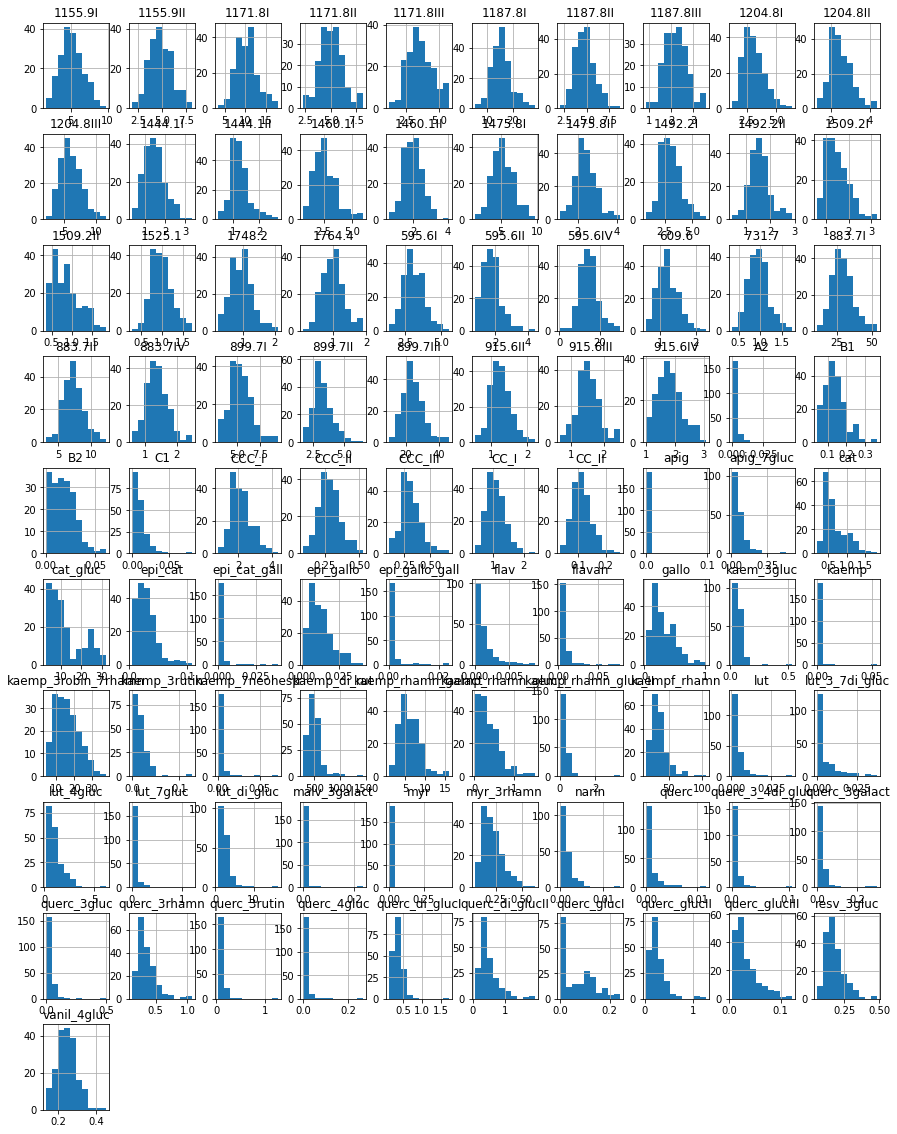

In [0]:
# histogram
hist = df.hist(figsize = (15,20))

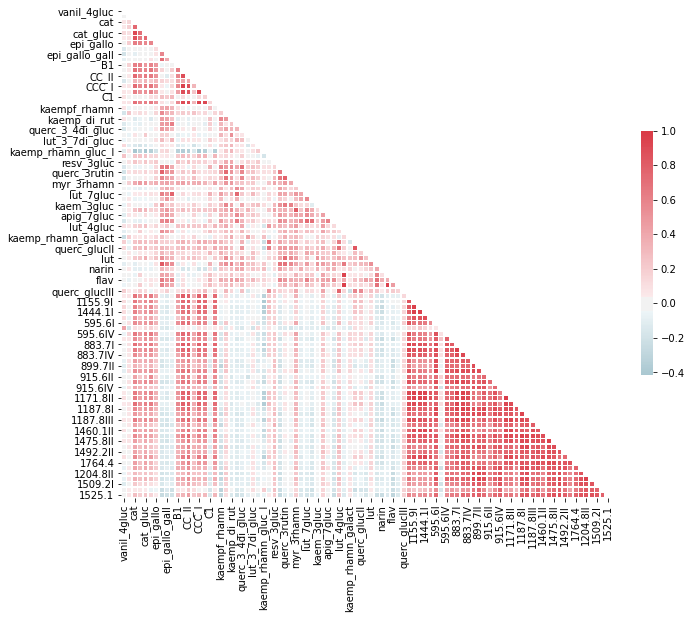

In [37]:
# Correlation

# Compute the correlation matrix 
correlation_matrix = df.drop('hull', axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
# Find the features with high correlation
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(list(correlated_features))   
# ['1171.8II', '883.7I', '1187.8I', '1155.9II', '1171.8I', '883.7II', 'kaemp', '1204.8III', '1444.1I']

(-300.0, 600.0, -40.0, 40.0)

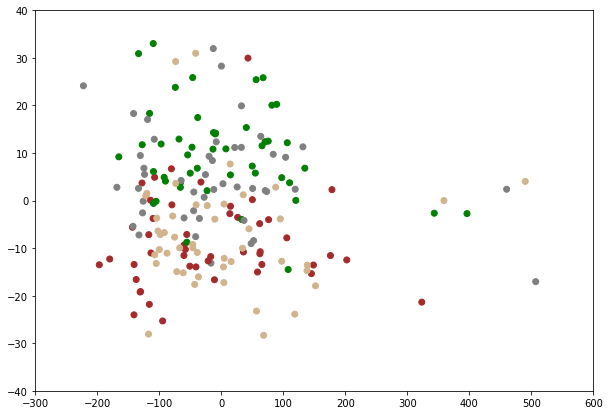

In [0]:
# PCA 

df_x = df.drop(['hull'], axis = 1)
color = df['hull'].tolist()
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(df_x))
pdf = pd.DataFrame(data = principalComponents
             , columns = ['one', 'two'])
a = pdf['one'].tolist()
b = pdf['two'].tolist()
plt.figure(figsize=(10,7))
plt.scatter(a,b, alpha=1, c = color)
plt.axis([-300, 600, -40, 40])

# Functions

In [0]:
def OHE_Y(df):
    y = np.asarray(df[['hull']])
    y = y.reshape(len(y),)
    label_encoder_y = LabelEncoder()
    label_encoder_y = label_encoder_y.fit(y)
    encoded_y = label_encoder_y.transform(y)
    return encoded_y

#plots a neat confusion matrix
def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)
        
def model_fit(model, df):
    df_x = df.drop(['hull'], axis = 1)
    y = OHE_Y(df)
    x = np.asarray(df_x)
    pt = PowerTransformer() # for standarizatiion of data with outliers; making mean = 0 and std = 1
    x = pt.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) #60/20/20
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    x_pred = model.predict(x_train)
    pretty_print_conf_matrix(y_pred, y_test, classes= ['Brown', 'Green', 'Grey', 'Tan'],
                            normalize=False, title='Confusion Matrix')
    print(classification_report(y_test, y_pred))
    return x_train, x_test, y_train, y_test

def pca(model):
    x = np.asarray(df_x)
    pt = PowerTransformer() 
    x = pt.fit_transform(x)
    y = OHE_Y(df)
    n_components = [20, 50, 70]
    for i in n_components:
      print('\n', 'n_component = ', i)
      pca = PCA(n_components=i)
      principalComponents = pca.fit_transform(np.array(df_x))
      model= model
      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)
      x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) 
      model.fit(x_train, y_train)
      y_pred = model.predict(x_test)
      pretty_print_conf_matrix(y_pred, y_test, classes= ['Tan', 'Green', 'Gray', 'Brown'],
                              normalize=False, title='Confusion Matrix')
      plt.show()
      print(classification_report(y_test, y_pred))

# Model # 1: RF

Original Model

              precision    recall  f1-score   support

           0       0.78      0.54      0.64        13
           1       0.60      0.75      0.67         8
           2       0.67      0.67      0.67         9
           3       0.70      0.88      0.78         8

    accuracy                           0.68        38
   macro avg       0.69      0.71      0.69        38
weighted avg       0.70      0.68      0.68        38



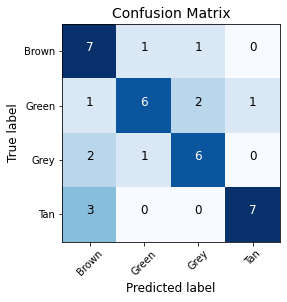

In [0]:
x_train, x_test, y_train, y_test = model_fit(RandomForestClassifier(), df)

Hyperparameters tuning

In [0]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 40],
    'max_features': [30, 70],
    'min_samples_leaf': [4,8],
    'min_samples_split': [8,  12],
    'n_estimators': [50, 200, 600]
}
# Create a based model
grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.8min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 70,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 50}

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.60      0.75      0.67         8
           2       0.75      0.67      0.71         9
           3       0.71      0.62      0.67         8

    accuracy                           0.71        38
   macro avg       0.71      0.70      0.70        38
weighted avg       0.72      0.71      0.71        38



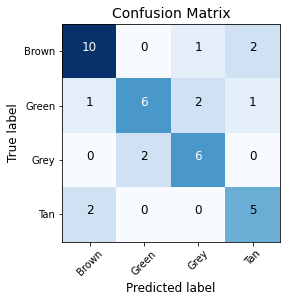

In [0]:
x_train, x_test, y_train, y_test = model_fit(RandomForestClassifier(bootstrap= True, max_depth= 10, max_features= 70, min_samples_leaf= 4,
                                 min_samples_split= 8, n_estimators= 50), df)

Applying PCA


 n_component =  20


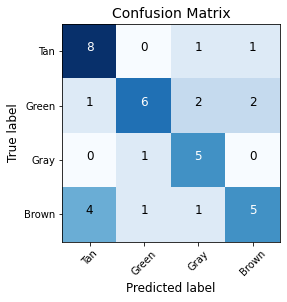

              precision    recall  f1-score   support

           0       0.80      0.62      0.70        13
           1       0.55      0.75      0.63         8
           2       0.83      0.56      0.67         9
           3       0.45      0.62      0.53         8

    accuracy                           0.63        38
   macro avg       0.66      0.64      0.63        38
weighted avg       0.68      0.63      0.64        38


 n_component =  50


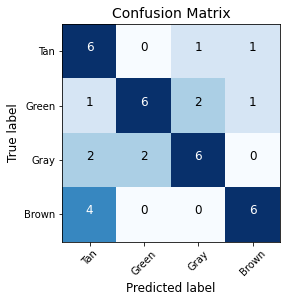

              precision    recall  f1-score   support

           0       0.75      0.46      0.57        13
           1       0.60      0.75      0.67         8
           2       0.60      0.67      0.63         9
           3       0.60      0.75      0.67         8

    accuracy                           0.63        38
   macro avg       0.64      0.66      0.63        38
weighted avg       0.65      0.63      0.63        38


 n_component =  70


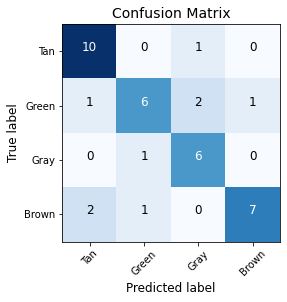

              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.60      0.75      0.67         8
           2       0.86      0.67      0.75         9
           3       0.70      0.88      0.78         8

    accuracy                           0.76        38
   macro avg       0.77      0.77      0.76        38
weighted avg       0.79      0.76      0.77        38



In [0]:
model= RandomForestClassifier(bootstrap= True, max_depth= 10, max_features= 20, min_samples_leaf= 4,
                              min_samples_split= 8, n_estimators= 50)
pca(model)

# Model # 2 : KNN

Original Model

              precision    recall  f1-score   support

           0       0.40      0.31      0.35        13
           1       0.40      0.50      0.44         8
           2       0.40      0.22      0.29         9
           3       0.46      0.75      0.57         8

    accuracy                           0.42        38
   macro avg       0.42      0.44      0.41        38
weighted avg       0.41      0.42      0.40        38



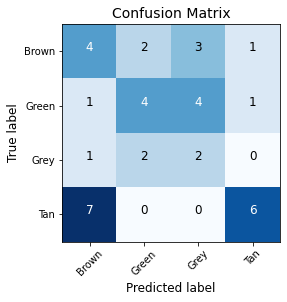

In [0]:
x_train, x_test, y_train, y_test = model_fit(KNeighborsClassifier(), df)

Hyperparameters tuning

In [0]:
model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5,10,20, 50], 
    'weights': [ 'uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan','minkowski']}
# Create a based model
grid_search = GridSearchCV(model, param_grid = param_grid, cv = 5)
# Fit the grid search to the data
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


              precision    recall  f1-score   support

           0       0.67      0.31      0.42        13
           1       0.40      0.50      0.44         8
           2       0.44      0.44      0.44         9
           3       0.46      0.75      0.57         8

    accuracy                           0.47        38
   macro avg       0.49      0.50      0.47        38
weighted avg       0.51      0.47      0.46        38



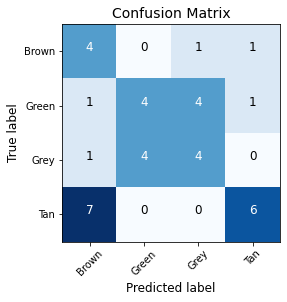

In [0]:
x_train, x_test, y_train, y_test = model_fit(KNeighborsClassifier(metric= 'euclidean', n_neighbors=3, weights= 'distance'), df)

Applying PCA


 n_component =  20


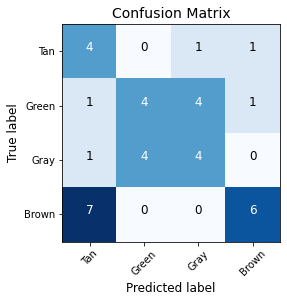

              precision    recall  f1-score   support

           0       0.67      0.31      0.42        13
           1       0.40      0.50      0.44         8
           2       0.44      0.44      0.44         9
           3       0.46      0.75      0.57         8

    accuracy                           0.47        38
   macro avg       0.49      0.50      0.47        38
weighted avg       0.51      0.47      0.46        38


 n_component =  50


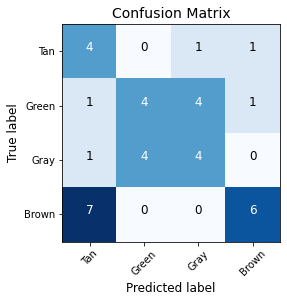

              precision    recall  f1-score   support

           0       0.67      0.31      0.42        13
           1       0.40      0.50      0.44         8
           2       0.44      0.44      0.44         9
           3       0.46      0.75      0.57         8

    accuracy                           0.47        38
   macro avg       0.49      0.50      0.47        38
weighted avg       0.51      0.47      0.46        38


 n_component =  70


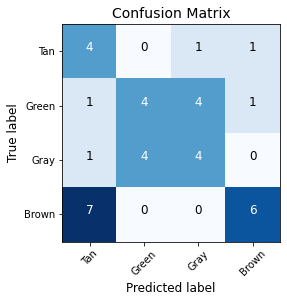

              precision    recall  f1-score   support

           0       0.67      0.31      0.42        13
           1       0.40      0.50      0.44         8
           2       0.44      0.44      0.44         9
           3       0.46      0.75      0.57         8

    accuracy                           0.47        38
   macro avg       0.49      0.50      0.47        38
weighted avg       0.51      0.47      0.46        38



In [0]:
model= KNeighborsClassifier(metric= 'euclidean', n_neighbors=3, weights= 'distance')
pca(model)

# Model # 3 : SVM

Original Model

              precision    recall  f1-score   support

           0       0.71      0.38      0.50        13
           1       0.50      0.50      0.50         8
           2       0.56      0.56      0.56         9
           3       0.50      0.88      0.64         8

    accuracy                           0.55        38
   macro avg       0.57      0.58      0.55        38
weighted avg       0.59      0.55      0.54        38



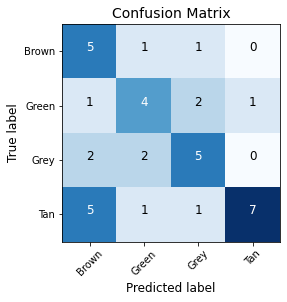

In [0]:
x_train, x_test, y_train, y_test = model_fit(SVC(), df)

Hyperparameters tuning

In [0]:
model = SVC()
param_grid = {
    'C': [ 0.1, 1, 10], 
    'gamma': [  0.1,0.01,0.001], # for rbf
    'kernel': ['rbf', 'poly'],
    'degree': [1,2,3]
}
# Create a based model
grid_search = GridSearchCV(model, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.50      0.50      0.50         8
           2       0.71      0.56      0.63         9
           3       0.70      0.88      0.78         8

    accuracy                           0.68        38
   macro avg       0.67      0.67      0.67        38
weighted avg       0.68      0.68      0.68        38



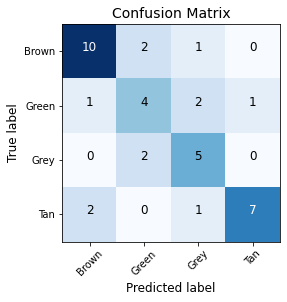

In [0]:
x_train, x_test, y_train, y_test =  model_fit(SVC(C= 10, gamma= 0.01, kernel= 'rbf', degree = 1), df)

Applying PCA


 n_component =  20


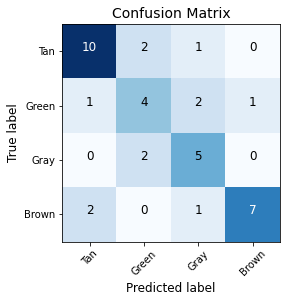

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.50      0.50      0.50         8
           2       0.71      0.56      0.63         9
           3       0.70      0.88      0.78         8

    accuracy                           0.68        38
   macro avg       0.67      0.67      0.67        38
weighted avg       0.68      0.68      0.68        38


 n_component =  50


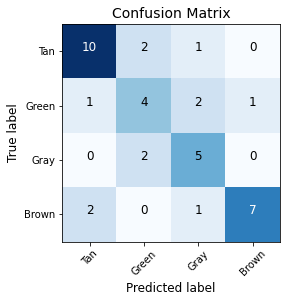

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.50      0.50      0.50         8
           2       0.71      0.56      0.63         9
           3       0.70      0.88      0.78         8

    accuracy                           0.68        38
   macro avg       0.67      0.67      0.67        38
weighted avg       0.68      0.68      0.68        38


 n_component =  70


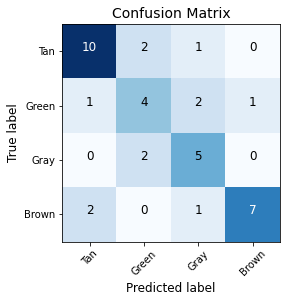

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.50      0.50      0.50         8
           2       0.71      0.56      0.63         9
           3       0.70      0.88      0.78         8

    accuracy                           0.68        38
   macro avg       0.67      0.67      0.67        38
weighted avg       0.68      0.68      0.68        38



In [0]:
model= SVC(C= 10, gamma= 0.01, kernel= 'rbf', degree = 1)
pca(model)

# Model # 4 : Neural Network

Original model

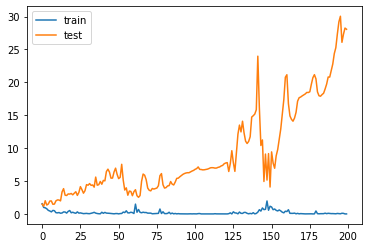

learning rate =  0.01 batch = 16 Accuracy: 68.42% 
 



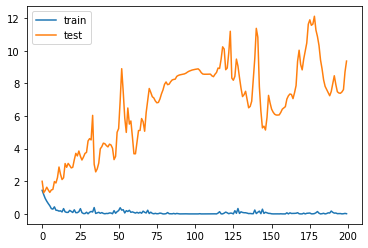

learning rate =  0.01 batch = 32 Accuracy: 60.53% 
 



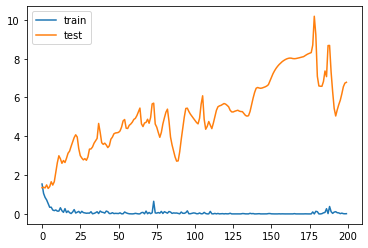

learning rate =  0.01 batch = 64 Accuracy: 68.42% 
 



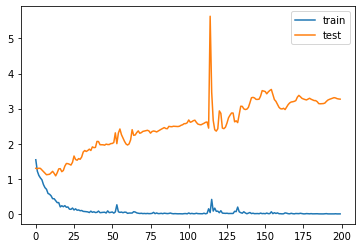

learning rate =  0.001 batch = 16 Accuracy: 63.16% 
 



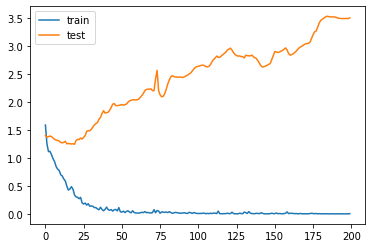

learning rate =  0.001 batch = 32 Accuracy: 63.16% 
 



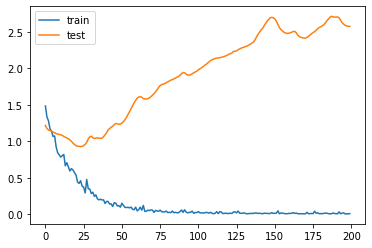

learning rate =  0.001 batch = 64 Accuracy: 68.42% 
 



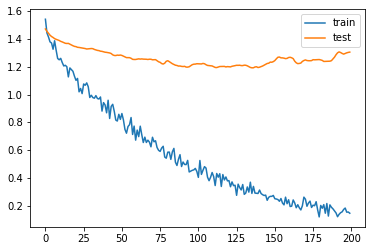

learning rate =  0.0001 batch = 16 Accuracy: 57.89% 
 



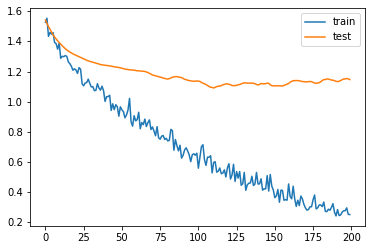

learning rate =  0.0001 batch = 32 Accuracy: 60.53% 
 



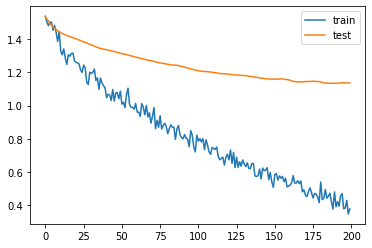

learning rate =  0.0001 batch = 64 Accuracy: 57.89% 
 



In [0]:
lrs = [ 0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]
epoch =200
for lr in lrs:
  for batch_size in batch_sizes:
    model=Sequential()
    model.add(Dense(200,input_dim=91,activation='relu')) # input dimention
    model.add(Dropout(0.3))
    model.add(Dense(100,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(30,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(lr= lr),metrics=['accuracy'])
    #model.summary()
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size= batch_size,epochs = epoch ,verbose=0)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    scores = model.evaluate(x_test, y_test, verbose=0)
    print('learning rate = ', lr, 'batch =', batch_size, "Accuracy: %.2f%%" % (scores[1]*100), '\n', '\n')

Hyperparameter tuning

Train on 114 samples, validate on 38 samples
Epoch 1/190
 - 0s - loss: 1.5146 - accuracy: 0.1754 - val_loss: 1.3782 - val_accuracy: 0.3158
Epoch 2/190
 - 0s - loss: 1.4064 - accuracy: 0.2895 - val_loss: 1.3495 - val_accuracy: 0.3684
Epoch 3/190
 - 0s - loss: 1.3433 - accuracy: 0.3246 - val_loss: 1.3311 - val_accuracy: 0.3684
Epoch 4/190
 - 0s - loss: 1.2873 - accuracy: 0.3947 - val_loss: 1.3150 - val_accuracy: 0.3421
Epoch 5/190
 - 0s - loss: 1.2289 - accuracy: 0.4211 - val_loss: 1.3084 - val_accuracy: 0.2895
Epoch 6/190
 - 0s - loss: 1.1987 - accuracy: 0.5088 - val_loss: 1.3052 - val_accuracy: 0.2632
Epoch 7/190
 - 0s - loss: 1.2387 - accuracy: 0.4737 - val_loss: 1.2961 - val_accuracy: 0.3421
Epoch 8/190
 - 0s - loss: 1.1383 - accuracy: 0.5000 - val_loss: 1.2834 - val_accuracy: 0.3684
Epoch 9/190
 - 0s - loss: 1.1243 - accuracy: 0.5614 - val_loss: 1.2779 - val_accuracy: 0.3684
Epoch 10/190
 - 0s - loss: 1.1114 - accuracy: 0.5877 - val_loss: 1.2563 - val_accuracy: 0.3421
Epoch 11/190
 

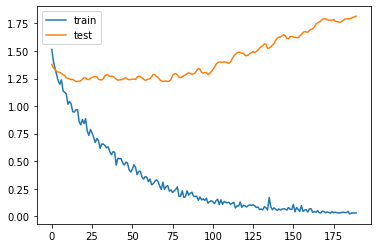

learning rate =  0.0001 batch = 16 Accuracy: 63.16% 
 



In [0]:
lrs = [ 0.0001]
batch_sizes = [16]
epoch = 190
for lr in lrs:
  for batch_size in batch_sizes:
    model=Sequential()
    model.add(Dense(400,input_dim=91,activation='relu')) # input dimention
    model.add(Dropout(0.3))
    model.add(Dense(200,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(lr= lr),metrics=['accuracy'])
    #model.summary()
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size= batch_size,epochs = epoch ,verbose=2)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    scores = model.evaluate(x_test, y_test, verbose=0)
    print('learning rate = ', lr, 'batch =', batch_size, "Accuracy: %.2f%%" % (scores[1]*100), '\n', '\n')

              precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       0.50      0.50      0.50         8
           2       0.50      0.56      0.53         9
           3       0.64      0.88      0.74         8

    accuracy                           0.63        38
   macro avg       0.63      0.64      0.62        38
weighted avg       0.66      0.63      0.63        38



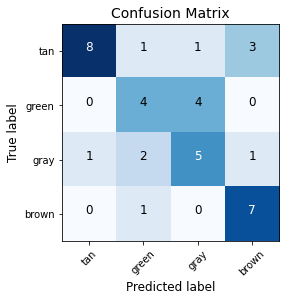

In [0]:
y_pred = []
for i in model.predict(x_test):
  y_pred.append(np.argmax(i))
pretty_print_conf_matrix(y_test, y_pred, classes= ['tan', 'green', 'gray', 'brown'],
                            normalize=False, title='Confusion Matrix')
print(classification_report(y_test, y_pred))

Applying PCA


 n_component =  20


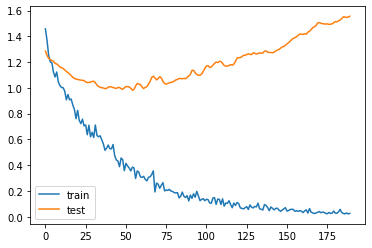

learning rate =  0.0001 batch = 16 Accuracy: 65.79% 
 


 n_component =  50


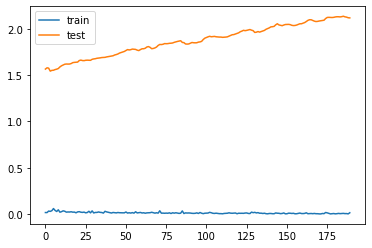

learning rate =  0.0001 batch = 16 Accuracy: 68.42% 
 


 n_component =  70


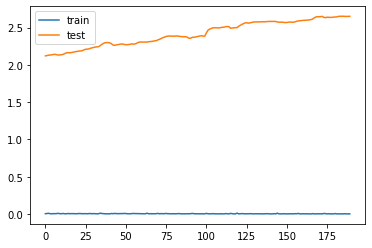

learning rate =  0.0001 batch = 16 Accuracy: 68.42% 
 



In [0]:
lrs = [ 0.0001]
batch_sizes = [16]
epoch = 190
for lr in lrs:
  for batch_size in batch_sizes:
    model=Sequential()
    model.add(Dense(400,input_dim=91,activation='relu')) # input dimention
    model.add(Dropout(0.3))
    model.add(Dense(200,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(lr= lr),metrics=['accuracy'])
    #model.summary()
    x = np.asarray(df_x)
    pt = PowerTransformer() 
    x = pt.fit_transform(x)
    y = OHE_Y(df)
    n_components = [20, 50, 70]
    for i in n_components:
      print('\n', 'n_component = ', i)
      pca = PCA(n_components=i)
      principalComponents = pca.fit_transform(np.array(df_x))
      history = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size= batch_size,epochs = epoch ,verbose=0)
      pyplot.plot(history.history['loss'], label='train')
      pyplot.plot(history.history['val_loss'], label='test')
      pyplot.legend()
      pyplot.show()
      scores = model.evaluate(x_test, y_test, verbose=0)
      print('learning rate = ', lr, 'batch =', batch_size, "Accuracy: %.2f%%" % (scores[1]*100), '\n', '\n')

# Interpretibility of the model

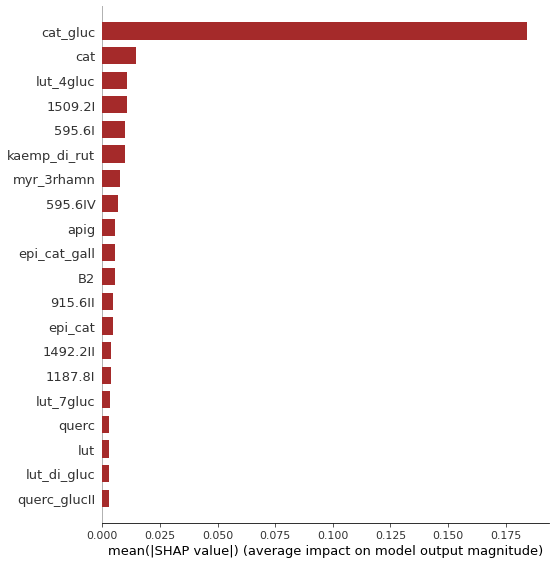

In [79]:
warnings.filterwarnings("ignore")
explainerRF = shap.TreeExplainer(model, x)
shap_values = explainerRF.shap_values(x)
shap.summary_plot(shap_values[0], x, plot_type='bar', color='brown')

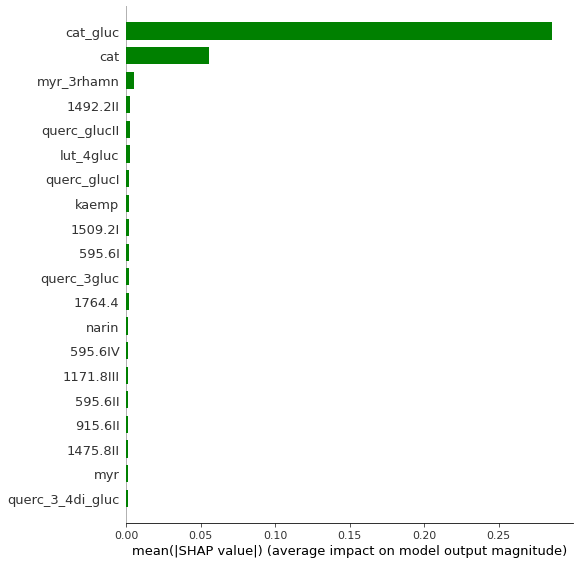

In [80]:
shap.summary_plot(shap_values[1], x, plot_type='bar', color='green')

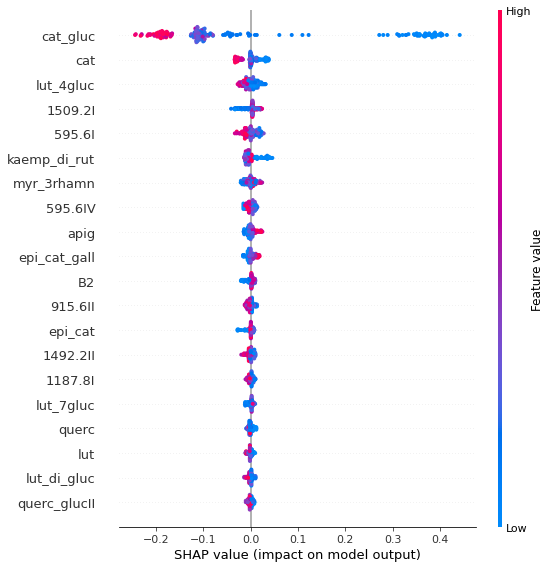

In [81]:
shap.summary_plot(shap_values[0], x)

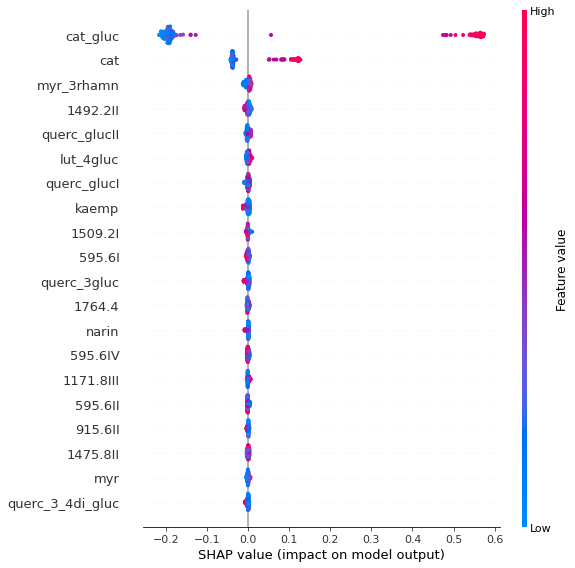

In [82]:
shap.summary_plot(shap_values[1], x)